In [1]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 400

/home/dbeckers/.conda/envs/postprocessing/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
def tophat(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 0.5 * width):
        return amplitude
    else:
        return 0.0

In [3]:
def gaussian(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return amplitude * math.exp( - ((x - convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [4]:
def yalla2021(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return math.cos(eta * (x-convected_distance)) * amplitude * math.exp( - ((x-convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [5]:
def tophatfv(func,x,dx,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs(abs((x-convected_distance) - center) - width / 2) < dx / 2) :
        return amplitude * (width / 2 - abs((x-convected_distance) - center) + dx / 2) / dx
    elif (abs((x-convected_distance) - center) < width / 2) :
        return amplitude
    else :
        return 0.0

In [6]:
center = 0.25
amplitude = 1.0
width = 0.0251646060
# width = 0.05
# width = 0.01
eta = 226.1946710304
t_final = 0.5
Lx = 1.0
function = yalla2021

In [7]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [13]:
root_dir = '/home/dbeckers/tests/scalar_advection'

In [123]:
# methods = ['godunov_ppm','godunov_weno_z','mol_central']
method_suffix = '_cfl_study'
grid_prefix = 'CFL_0.1_'
# methods = ['godunov_ppm']
# methods = ['godunov_weno_z']
# methods = ['mol_central_CFL_0.5']
methods = ['godunov_ppm','godunov_weno_z']
# methods = ['mol_central','periodic_mol_central']


case = 'yalla2021/eta_2'
# case = 'tophat'
# case = 'gaussian'
# grid_types = ['uniform','fine_to_coarse']
grid_types = ['fine_to_coarse']
# grid_types = ['uniform']
grid_sizes = [64*2**i for i in range(5)]
dx_list = [Lx/grid_size for grid_size in grid_sizes]
print(grid_sizes)
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

[64, 128, 256, 512, 1024]


In [129]:
# idx = 5
idx = -1
fields = ["x","temperature"]

In [130]:
%%capture
fig1, ax1 = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))
fig3, ax3 = plt.subplots(figsize=(10, 6))
fig4, ax4 = plt.subplots(figsize=(10, 6))

error_lists = [[[] for i in range(len(grid_types))] for j in range(len(methods))]

k = -1
for method in methods:
    k += 1
    g = -1
    for grid_type in grid_types:
        g += 1
        l = -1
        for grid_size in grid_sizes:
            l += 1
            case_dir = os.path.join(root_dir, method+method_suffix, case, grid_type, grid_prefix+f'nx_{grid_size}')
            
            # Load plt files
            plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
            ds = yt.load(plt_files[idx])
            ray = ds.ortho_ray(0, (0, 0))
            srt = np.argsort(ray["x"])
            df = pd.DataFrame({f: np.array(ray[f][srt]) for f in fields})
            t = ds.current_time.value.flatten()[0]
            df["time"] = t
            df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
            
            # Plot error
            error_file = os.path.join(case_dir,'error.log')
            with open(error_file) as f:
                lines = f.readlines()
                error_levels = len(lines[1].split())-1
                time = [float(line.split()[0]) for line in lines]
                for level in reversed(range(error_levels)):
                    error = [float(line.split()[level+1]) for line in lines]
                    ax1.plot(time, error, color=color_list[l], linestyle=linestyle_list[k], linewidth=linewidth_list[g],label=f'{method}; nx = {grid_size}; grid type = {grid_type}; level {level}')
           
            # Plot scalar distribution
            ax2.plot(df["x"].values, df["temperature"].values, color=color_list[l], label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', linewidth=linewidth_list[g], linestyle=linestyle_list[k])
            
            # Add error to list for log-log plot
            error_lists[k][g].append(error[-1])
            
        ax4.plot(dx_list,error_lists[k][g],linestyle=linestyle_list[k],linewidth=linewidth_list[g],color='black',label=f'{method}; grid type = {grid_type}')


x_exact = np.linspace(0, 1, num=10000)
scalar_exact = [function(xi,center,amplitude,width,eta,t) for xi in x_exact]
ax2.plot(x_exact, scalar_exact, label = f'exact solution; t = {t}', color="black", linestyle="dashed", linewidth=0.5)

ax4.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2')
ax4.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3')
ax4.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4')


yt : [INFO     ] 2022-08-03 23:39:43,903 Parameters: current_time              = 0.500000000000005
yt : [INFO     ] 2022-08-03 23:39:43,904 Parameters: domain_dimensions         = [64  4  4]
yt : [INFO     ] 2022-08-03 23:39:43,904 Parameters: domain_left_edge          = [ 0.      -0.03125 -0.03125]
yt : [INFO     ] 2022-08-03 23:39:43,905 Parameters: domain_right_edge         = [1.      0.03125 0.03125]
yt : [INFO     ] 2022-08-03 23:39:44,543 Parameters: current_time              = 0.4999999999999883
yt : [INFO     ] 2022-08-03 23:39:44,544 Parameters: domain_dimensions         = [128   4   4]
yt : [INFO     ] 2022-08-03 23:39:44,544 Parameters: domain_left_edge          = [ 0.       -0.015625 -0.015625]
yt : [INFO     ] 2022-08-03 23:39:44,545 Parameters: domain_right_edge         = [1.       0.015625 0.015625]
yt : [INFO     ] 2022-08-03 23:39:45,112 Parameters: current_time              = 0.49999999999997996
yt : [INFO     ] 2022-08-03 23:39:45,113 Parameters: domain_dimensions   

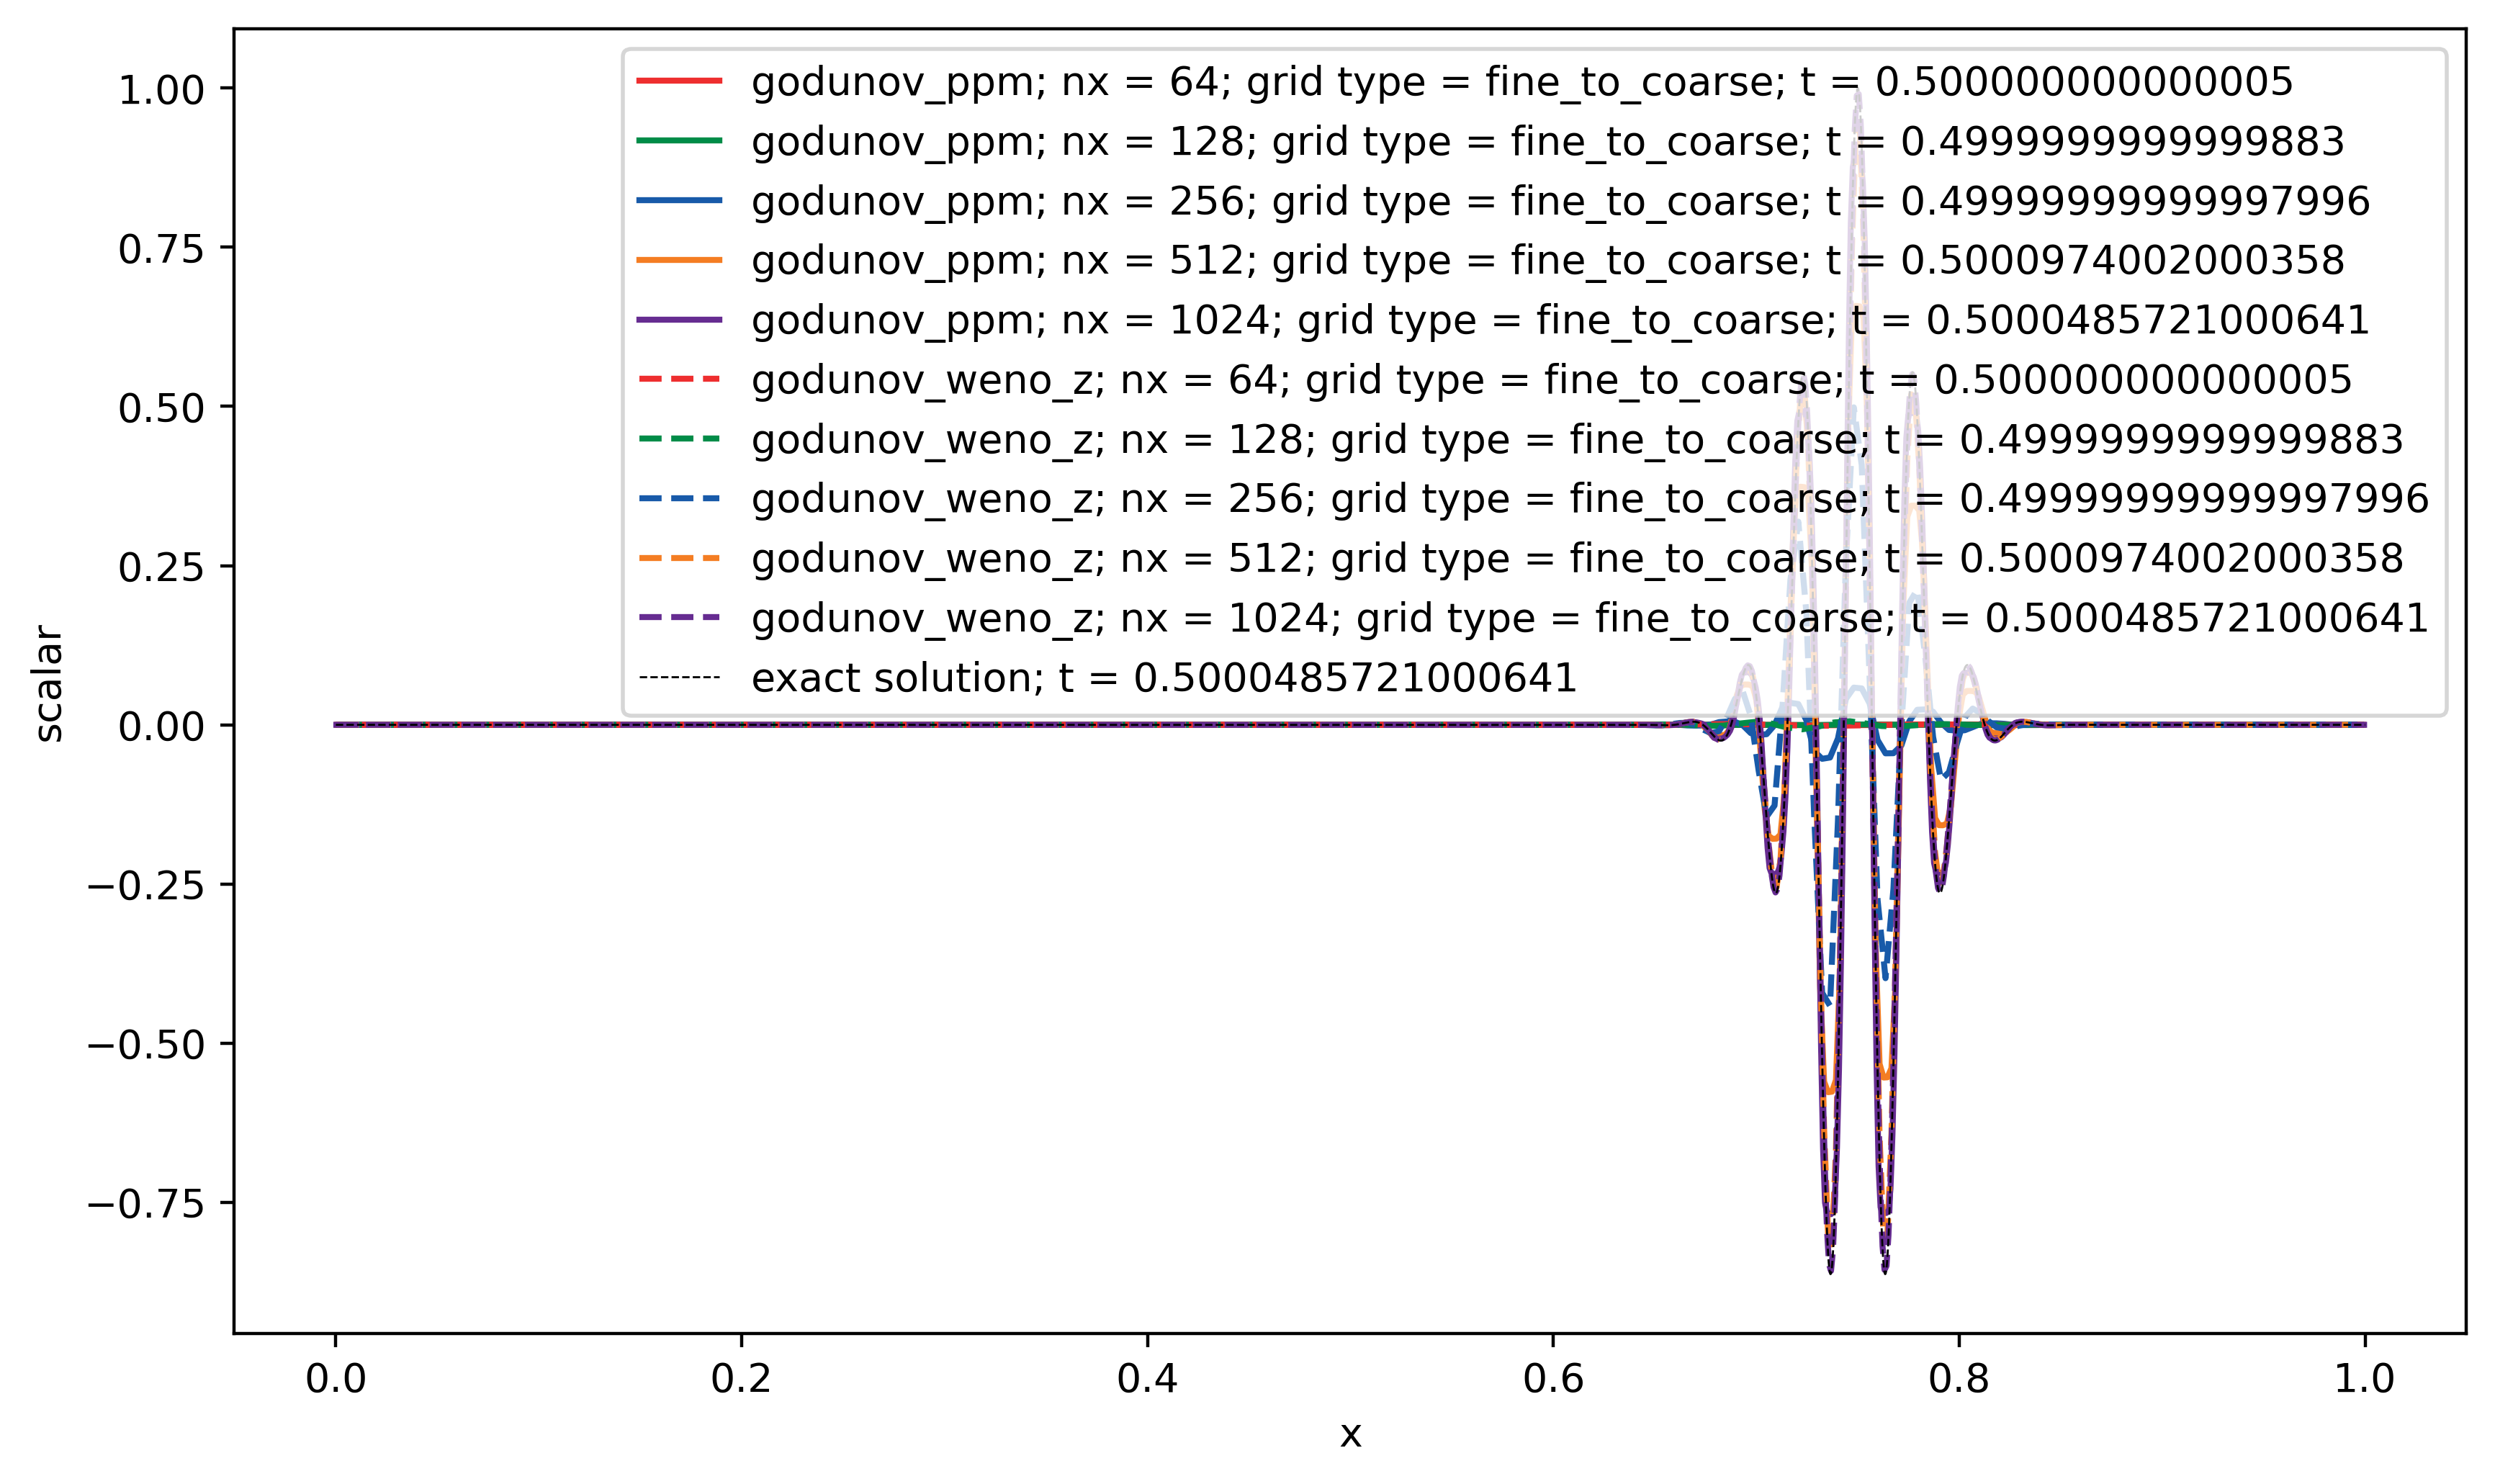

In [131]:
ax2.set_xlabel('x')
ax2.set_ylabel('scalar')
ax2.set_title('')
ax2.legend()
# ax2.set_ylim([-0.1,1.1])

# ax2.set_ylim([-0.01,0.01])
# ax2.set_xlim([0.4,0.7])
# ax2.set_xlim([0.1,0.4])
fig2

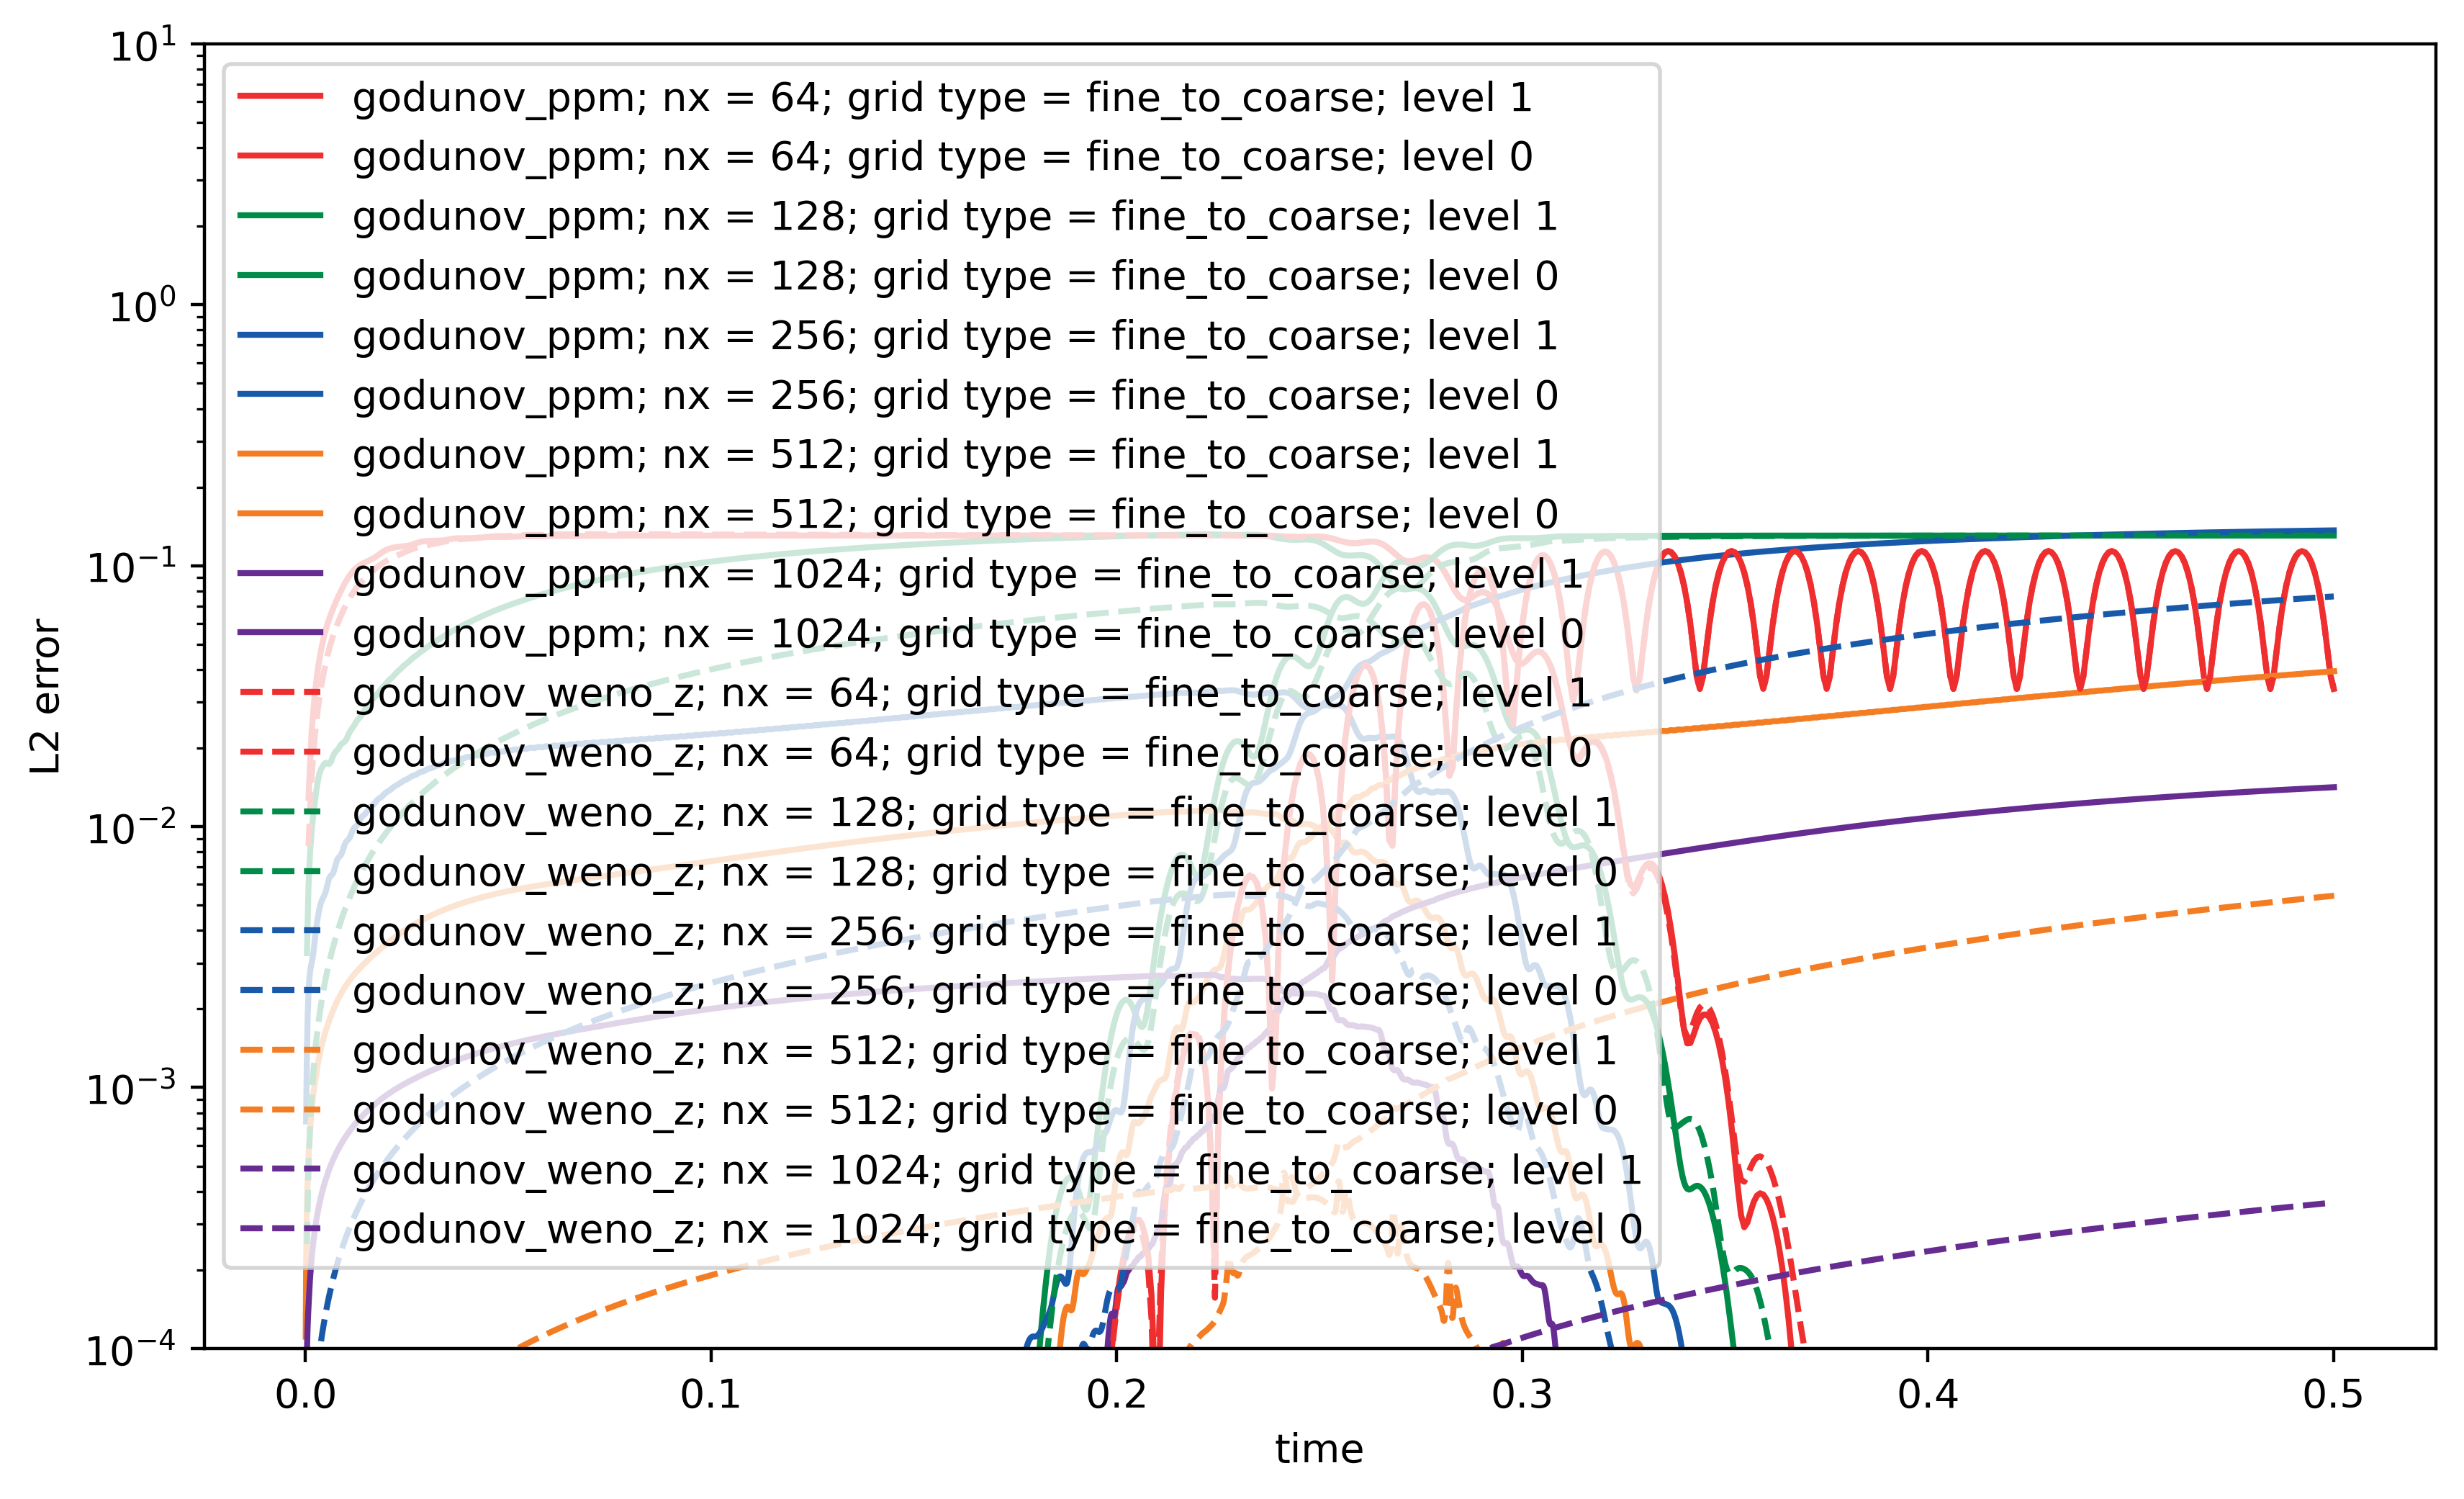

In [134]:
ax1.set_xlabel('time')
ax1.set_ylabel('L2 error')
ax1.set_title('')
ax1.legend()
ax1.set_yscale('log')
ax1.set_ylim([1e-4,1e1])
# ax1.axvline(0.25+width/2,0,1)
# ax1.axvline(0.25-width/2,0,1)
fig1

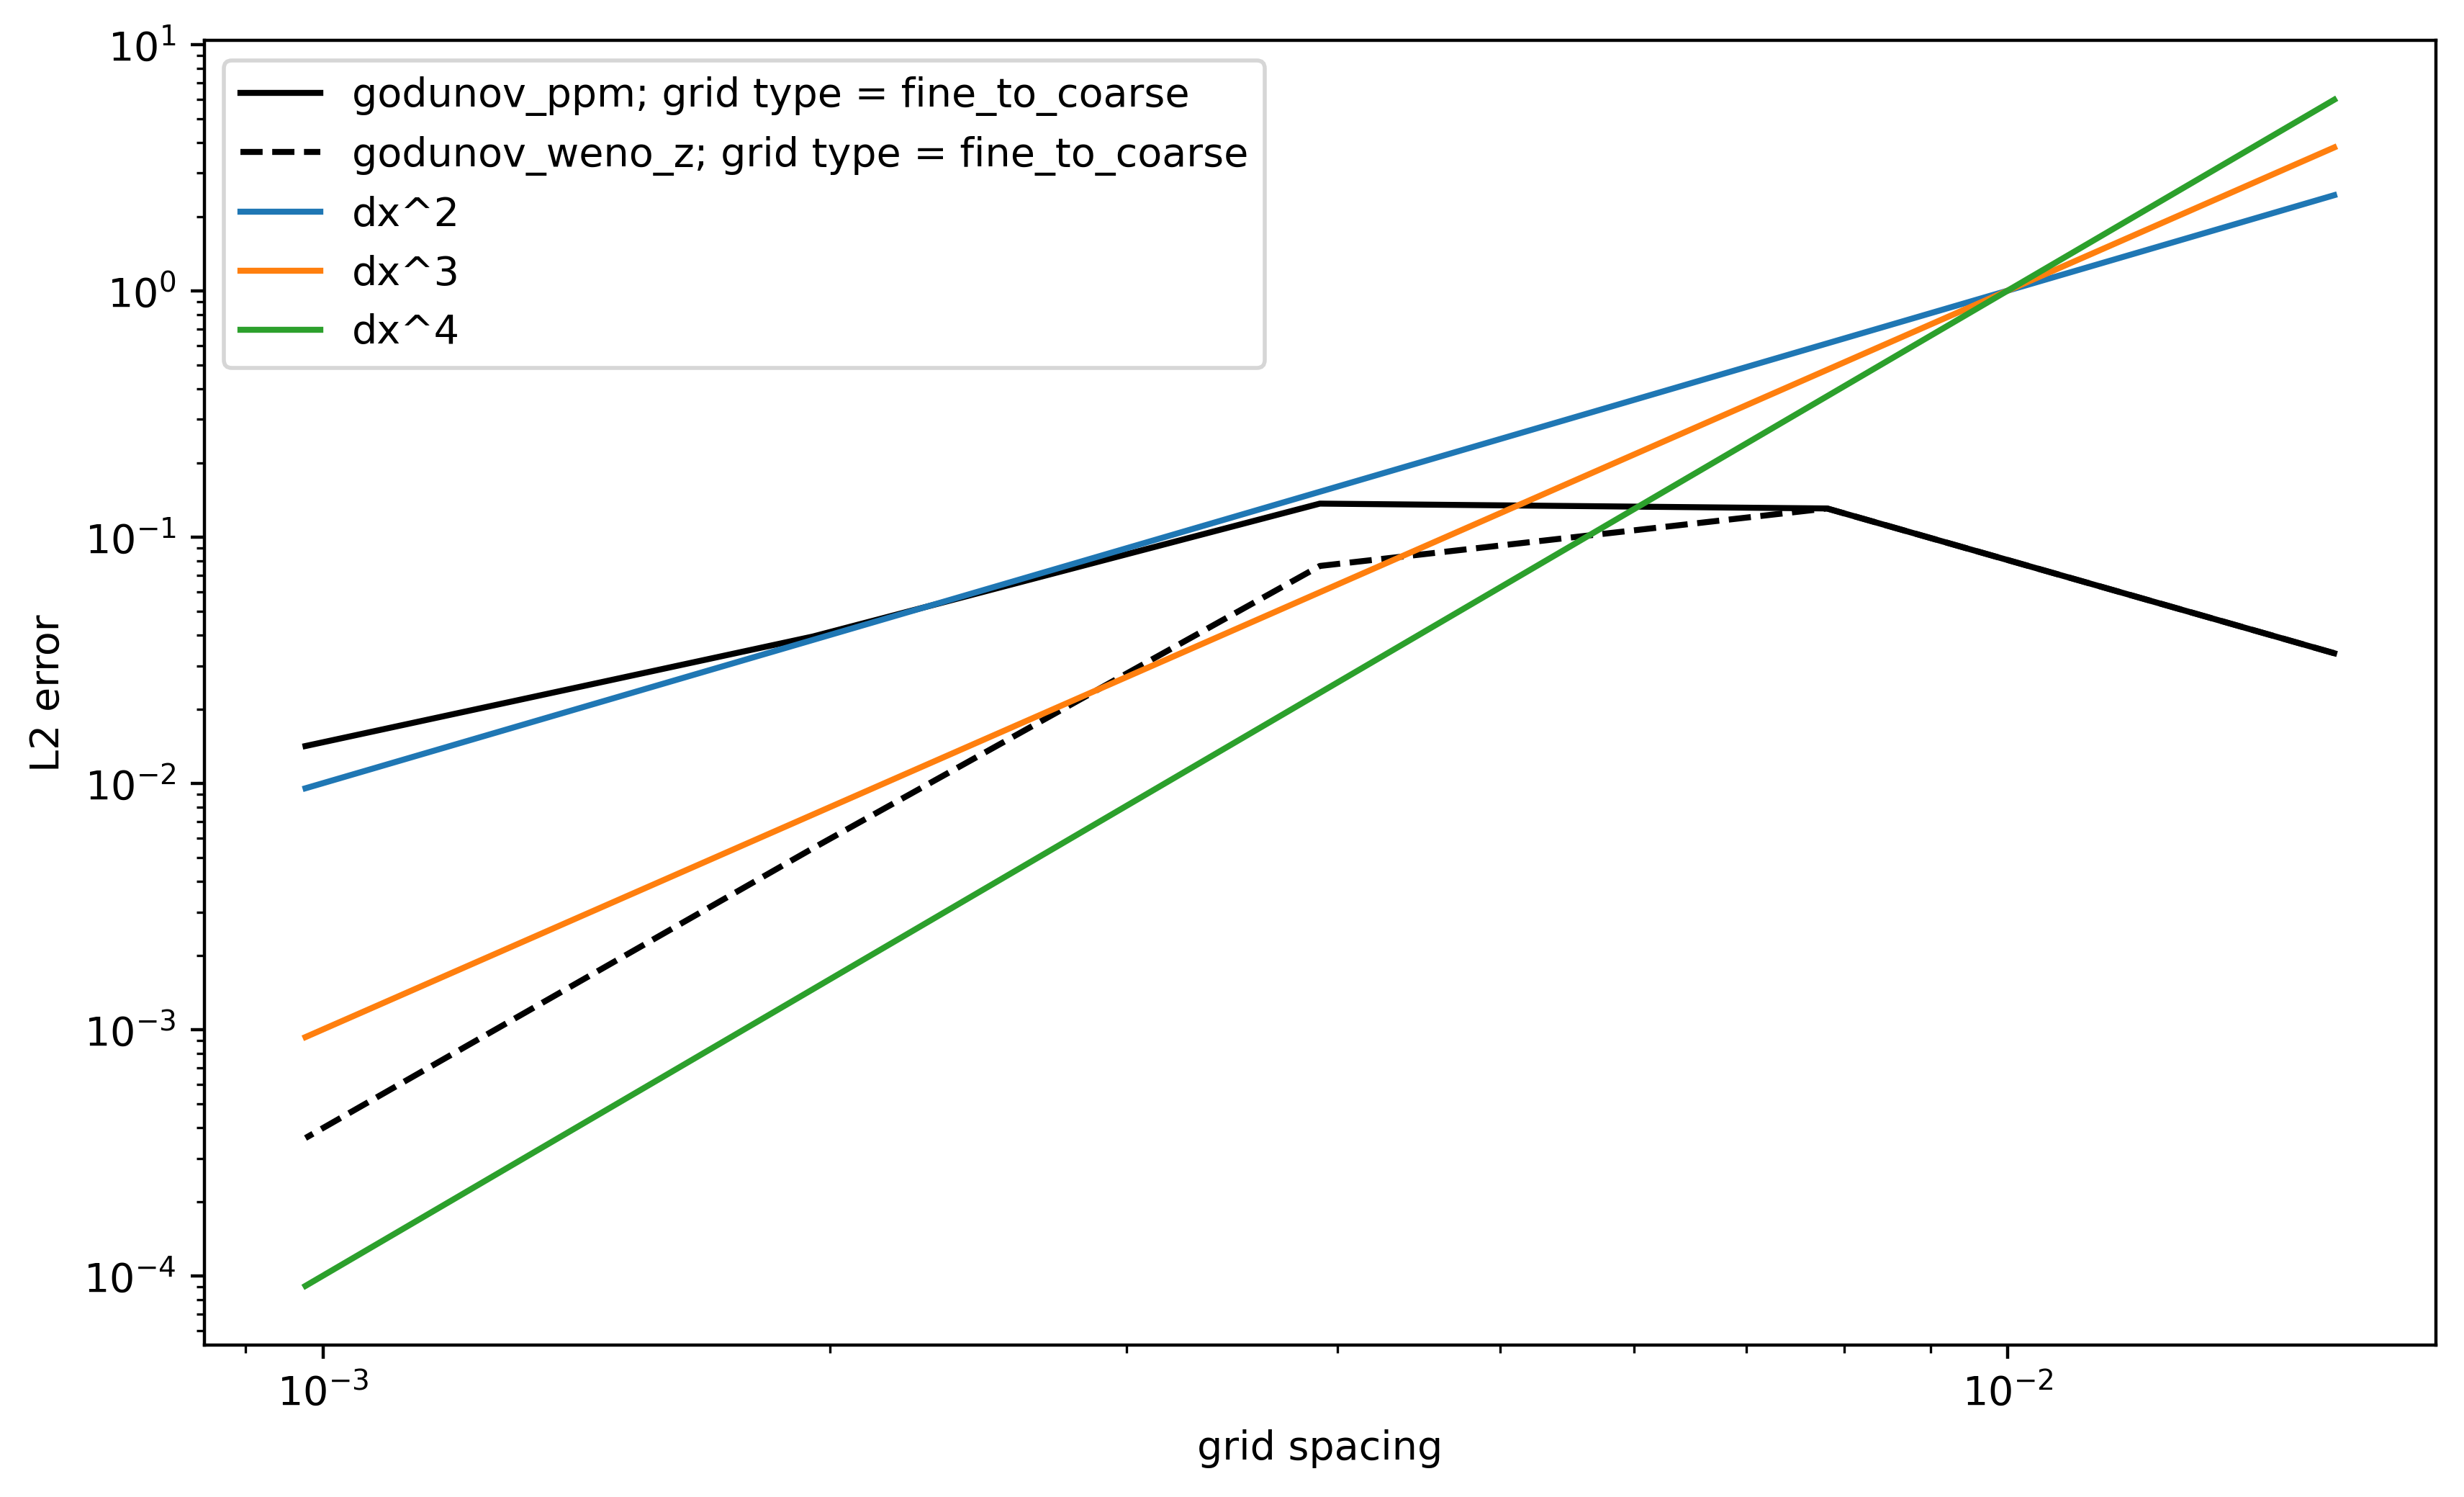

In [133]:
ax4.set_xlabel('grid spacing')
ax4.set_ylabel('L2 error')
ax4.set_title('')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.legend()

# ax4.set_ylim([1e-4,1])
fig4

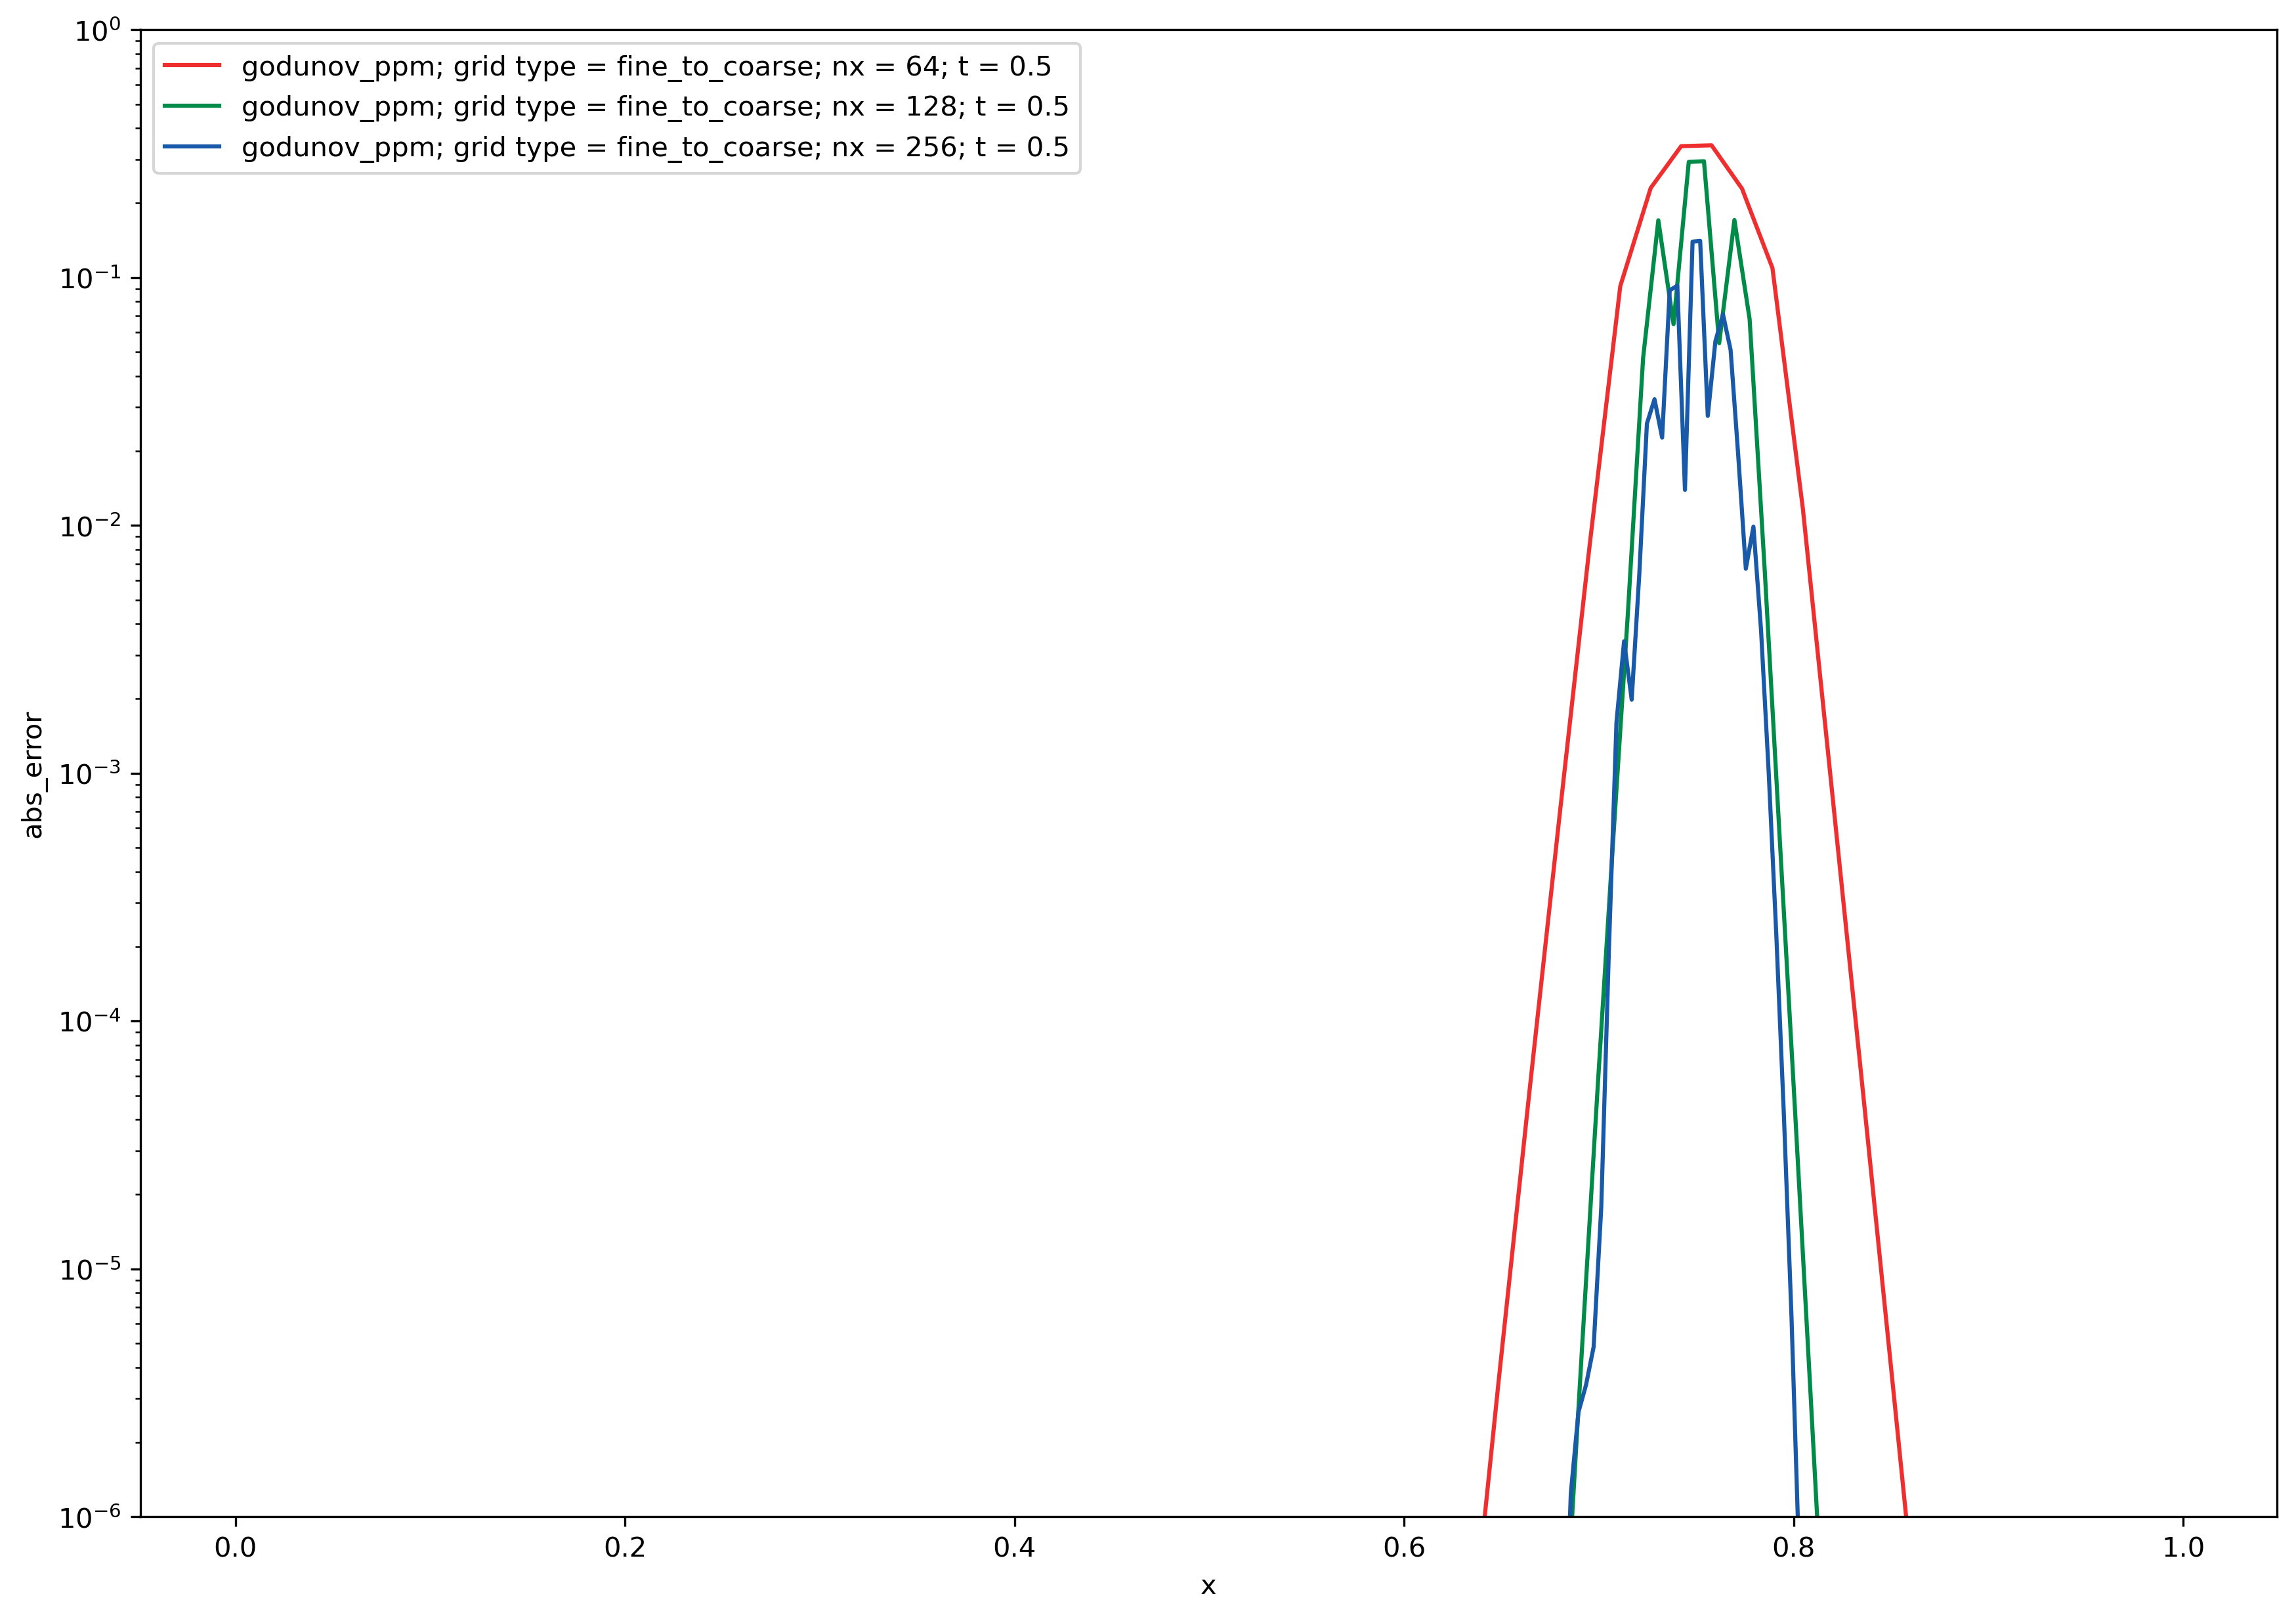

In [215]:
ax3.set_xlabel('x')
ax3.set_ylabel('abs_error')
ax3.set_title('')
ax3.legend()
ax3.set_yscale('log')
ax3.set_ylim([1e-6,1])
fig3